# Project: China Scientific Leadership

**Notebook:** Fig1_cd_Fig4c_China_parity_trend.ipynb

**Authors:** Renli Wu, Christopher Esposito, James Evans

**Affiliations:** School of Information Management, Wuhan University / Knowledge Lab, University of Chicago / University of California, Los Angeles

**Date:** 2024-11-29 (UTC)
**Version:** v0.3.0

**Purpose:**
This notebook generates **Figure 1c**, **Figure 1d**, and **Figure 4c** for the main text.
It can also produce several supplementary figures (**Fig. S12, Fig. S15, Fig. S16, Fig. S17, Fig. S30**).

**Inputs:**
- `data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz`

**Outputs:**
- `pics/fig_1_cd.svg`
- `pics/fig_4_c.svg`

**Notes:**
See `README.md` for environment setup, dependencies, and execution order within the analysis pipeline.


In [1]:
import numpy as np
import pandas as pd
import time

### Load the leadership dataset

In [2]:
%%time
print(time.strftime('%l:%M%p %Z on %b %d, %Y'))
data = pd.read_csv("./data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz", compression="gzip")
print(time.strftime('%l:%M%p %Z on %b %d, %Y'), data.shape)
file_name_label = ""
# >>> Toggle label for output variants. Options such as "_WOS_Matched" or "_Remove_Honorary_Author"
# indicate filtered datasets. Uncomment the lines below to exclude honorary authors
# or to restrict the corpus to articles matched in Web of Science (WOS), thereby
# generating alternative analytical baselines.

# data = data[data["Honorary_authors"] != True]    # Exclude honorary authors
# data = data[data["Matched_in_WOS"] == True]     # Restrict to WOS-matched articles

print(time.strftime('%l:%M%p %Z on %b %d, %Y'), data.shape)
data.head()

 5:02AM CDT on Sep 17, 2025


<timed exec>:2: DtypeWarning: Columns (9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.


 5:05AM CDT on Sep 17, 2025 (42995311, 22)
 5:05AM CDT on Sep 17, 2025 (42995311, 22)
CPU times: user 1min 58s, sys: 10.5 s, total: 2min 8s
Wall time: 2min 10s


,paperId,authorId,publication_year,Lead_Pro,region,China_US,China_EU+,China_UK,US_EU+,UK_EU+,...,China_BeltRoad_HighIncome,China_BeltRoad_LowIncome,US_BeltRoad_HighIncome,US_BeltRoad_LowIncome,jif_2021,jif_mid,11_technical_area,fos_6,Honorary_authors,Matched_in_WOS
0,W3135965258,A5021665664,2021,0.155624,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
1,W3135965258,A5032223512,2021,0.263628,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
2,W3135978430,A5058653785,2021,0.300942,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
3,W3135978430,A5062473161,2021,0.689903,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
4,W3135978430,A5006524513,2021,0.242909,Latin America,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True


### Main text - China Lead share and Lead premium with different partners

In [3]:
# =========================
# - Computes yearly slope metrics
# - Draws two 2×2 panels (top row: plots; bottom row: legends)
# - Panel A: China vs US/UK/EU+ (lead_share & lead_premium)
# - Panel B: China vs BeltRoad groups (lead_share & lead_premium)
# =========================

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator

In [5]:
# ---------- Params ----------
# c1 defines the focal country/region whose leadership dynamics are examined.
# Changing c1 (e.g., "China", "U.S.", "U.K.", "EU+") enables analysis of different
# perspectives on lead share and lead premium. Note: BeltRoad-related regions
# ("BeltRoad_HighIncome", "BeltRoad_LowIncome") are valid counterparts only
# when c1 is set to "China" or "U.S.".
c1 = "China"  # focal lead country
begin_year = 2010
lead_threshold = 0.65
c2_candidates = ["China", "U.S.", "U.K.", "EU+", "BeltRoad_HighIncome", "BeltRoad_LowIncome"]
c2_candidates = [c for c in c2_candidates if c != c1]


In [6]:
# ---------- Helpers ----------
def _kfmt(x, _pos):  # y-axis format
    if x >= 1000:
        r = np.round(x/1000, 1)
        return f"{int(r)}k" if r == int(r) else f"{r}k"
    return str(int(x))

def _mid(iv: pd.Interval) -> float:
    return float(iv.mid)

def _bins(n=20):
    return np.linspace(0, 1, n+1)

def compute_slope_metrics(df, c1, c2_list, begin_year, lead_threshold, nbins=20):
    """Compute lead_share/premium for each c2."""
    results = []
    # Preselect necessary columns
    cols_needed = {"paperId","authorId","Lead_Pro","publication_year","region"}
    for c2 in c2_list:
        # Try c1_c2 first, otherwise use c2_c1
        pair_col = f"{c1.replace('.', '')}_{c2.replace('.', '')}"
        if pair_col not in df.columns:
            pair_col = f"{c2.replace('.', '')}_{c1.replace('.', '')}"
        obs = df[df[pair_col] == True][list(cols_needed)].drop_duplicates(["paperId","authorId","region"]).copy()
        for y in range(begin_year, 2024):
            sub = obs.loc[obs["publication_year"].between(y, y)].copy()  # one-year window
            if sub.empty:
                continue
            sub.loc[:, "val_bins"] = pd.cut(sub["Lead_Pro"], bins=_bins(nbins), include_lowest=True)
            sta = (
                sub.groupby(["region", "val_bins"], observed=True)
                   .size().rename("count").reset_index())
            sta["val_midpoints"] = sta["val_bins"].apply(_mid).astype(float)
            # Wide table with counts by region; fill missing to 0
            wide = (sta.pivot(index="val_midpoints", columns="region", values="count")
                        .reindex(columns=[c1, c2]).fillna(0.0).reset_index())
            # Diff (% share of c1 among c1+c2)
            denom = wide[[c1, c2]].sum(axis=1)
            with np.errstate(divide='ignore', invalid='ignore'):
                diff = np.where(denom > 0, (wide[c1] / denom) * 100.0, np.nan)
            w2 = wide.loc[(wide["val_midpoints"]>=0.15) & (wide["val_midpoints"]<=0.85) & np.isfinite(diff), ["val_midpoints"]].copy()
            w2["diff"] = diff[(wide["val_midpoints"]>=0.15) & (wide["val_midpoints"]<=0.85) & np.isfinite(diff)]
            if len(w2) >= 2:
                slope, intercept = np.polyfit(w2["val_midpoints"].to_numpy(), w2["diff"].to_numpy(), 1)
            else:
                slope, intercept = np.nan, np.nan

            # Lead vs muscle counts by threshold
            c1_lead = wide.loc[wide["val_midpoints"] >  lead_threshold, c1].sum()
            c2_lead = wide.loc[wide["val_midpoints"] >  lead_threshold, c2].sum()
            c1_musc = wide.loc[wide["val_midpoints"] <= lead_threshold, c1].sum()
            c2_musc = wide.loc[wide["val_midpoints"] <= lead_threshold, c2].sum()

            ls_denom = c1_lead + c2_lead
            c1_lead_share = c1_lead / ls_denom if ls_denom>0 else np.nan
            musc_denom = c1_musc + c2_musc
            lead_premium = (c1_lead / ls_denom - c1_musc / musc_denom) if (ls_denom>0 and musc_denom>0) else np.nan
            results.append([c1, c2, slope, intercept, c1_lead_share, lead_premium, y, y, sub["paperId"].nunique()])
    out = pd.DataFrame(results, columns=["c1","c2","slope","intercept","c1_lead_share","lead_premium",
                                         "st_year","end_year","pub_num"])
    out["year"] = out["st_year"]
    return out

def _pair_color(label, color_dict, default="green"):
    if label in color_dict: return color_dict[label]
    rev = "/".join(label.split("/")[::-1])
    return color_dict.get(rev, default)

def _setup_axis_common(ax, x_min, x_max, begin_year, highlight_year=2023):
    ax.set_xlim(x_min, x_max)
    ticks = np.arange(begin_year, 2031, 5).tolist()
    if highlight_year not in ticks: ticks.append(highlight_year)
    ticks.sort()
    ax.xaxis.set_major_locator(FixedLocator(ticks))
    for t in ax.get_xticklabels():
        t.set_fontsize(18)
        t.set_color("grey" if int(t.get_text()) == highlight_year else "#000000")
    ax.axvline(highlight_year, color="black", linestyle="solid", linewidth=3, alpha=0.7, zorder=1)
    ax.tick_params(axis='both', which='both', labelsize=18, pad=10)

In [7]:
def plot_two_panels(
    panel_name,
    pairs_order,                      # iterable of c2 values (countries)
    color_dict,                       # mapping from "China/COUNTRY" to color
    settings,                         # dict for metrics
    file_suffix,                      # filename suffix
    x_min, x_max, save_file_name
):
    plt.style.use('fivethirtyeight')
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(13, 7),
        gridspec_kw={'height_ratios': [3, 2], 'wspace': 0.1, 'hspace': 0.1},
        constrained_layout=True
    )

    axes = axes.flatten()

    legend_share, legend_prem = [], []

    for idx, (metric_key, cfg) in enumerate(settings.items()):
        # left panel: lead_share (primary y); right panel: lead_premium (secondary y)
        if metric_key == "lead_premium":
            ax = axes[idx].twinx()
            axes[idx].yaxis.set_visible(False)
        else:
            ax = axes[idx]

        df_scatter = cfg["df_scatter"]
        df_now     = cfg["df_current"]
        df_future  = cfg["df_future"]

        for c2 in pairs_order:
            label = f"{c1}/{c2}"
            color = _pair_color(label, color_dict)
            s_df  = df_scatter[df_scatter['Country Pair'] == label]
            n_df  = df_now[df_now['Country Pair'] == label]
            f_df  = df_future[df_future['Country Pair'] == label]

            # scatter
            sns.scatterplot(data=s_df, x='Year', y='Actual', color=color, s=100, ax=ax, legend=False)
            # current line + CI
            sns.lineplot(data=n_df, x='Year', y='Predictions', linewidth=4, color=color, ax=ax, legend=False)
            sns.lineplot(data=n_df, x='Year', y='Lower Bound', linewidth=2, color=color, linestyle='--', ax=ax, legend=False)
            sns.lineplot(data=n_df, x='Year', y='Upper Bound', linewidth=2, color=color, linestyle='--', ax=ax, legend=False)
            ax.fill_between(n_df['Year'], n_df['Lower Bound'], n_df['Upper Bound'], color=color, alpha=0.2)
            # future line + CI
            sns.lineplot(data=f_df, x='Year', y='Predictions', linewidth=4, color=color, linestyle='dashed', ax=ax, legend=False)
            sns.lineplot(data=f_df, x='Year', y='Lower Bound', linewidth=2, color=color, linestyle='--', ax=ax, legend=False)
            sns.lineplot(data=f_df, x='Year', y='Upper Bound', linewidth=2, color=color, linestyle='--', ax=ax, legend=False)
            ax.fill_between(f_df['Year'], f_df['Lower Bound'], f_df['Upper Bound'], color=color, alpha=0.2)

            # legend text (from current df)
            if not n_df.empty and 'Legend Text' in n_df.columns:
                legend_text = f"{label}\n{cfg['ylabel']} {n_df['Legend Text'].iloc[0]}"
            else:
                legend_text = f"{label}\n{cfg['ylabel']}"

            le = Line2D([0], [0], color=color, lw=4, label=legend_text)
            (legend_share if metric_key=="lead_share" else legend_prem).append(le)

        # y-axis config
        ax.set_ylim(cfg["ylim"])
        ax.axhline(cfg["equal_line"], color="black", linestyle="solid", linewidth=3, alpha=0.7, zorder=1)
        ax.yaxis.set_major_locator(FixedLocator(np.arange(cfg["ylim"][0], cfg["ylim"][1] + 1e-9, 0.25)))
        ax.set_yticklabels([f"{i:.2f}" for i in np.arange(cfg["ylim"][0], cfg["ylim"][1] + 1e-9, 0.25)])
        for lbl in ax.get_yticklabels():
            lbl.set_fontsize(21)
        _setup_axis_common(axes[idx], x_min, x_max, begin_year, highlight_year=2023)

        # labels
        if metric_key == "lead_share":
            ax.set_ylabel(cfg["ylabel"], labelpad=5, fontsize=25)
        else:
            ax.yaxis.set_label_position("left")
            ax.yaxis.tick_left()
            ax.set_ylabel(cfg["ylabel"], labelpad=5, fontsize=25) #, rotation=270
            # ensure tick labels of twin y-axis use same font/size
            for lbl in ax.get_yticklabels():
                lbl.set_fontsize(21)
        axes[idx].set_xlabel("Year", labelpad=5, fontsize=25)

        # hide auto legends
        leg = ax.get_legend()
        if leg is not None: leg.set_visible(False)

    # bottom cells for legends
    axes[2].axis('off'); axes[3].axis('off')

    # Legend: left bottom for lead_share
    legend1 = axes[2].legend(handles=legend_share, bbox_to_anchor=(-0.2, 0.5), loc='center left', prop={'size': 21, 'weight': 'bold'})
    legend1.get_frame().set_linewidth(0)
    for line, text in zip(legend1.get_lines(), legend1.get_texts()):
        text.set_color(line.get_color());  text.set_fontsize(20)
        line.set_linewidth(0)
    axes[2].add_artist(legend1)

    # Legend: right bottom for lead_premium
    legend2 = axes[3].legend(handles=legend_prem, bbox_to_anchor=(-0.1, 0.5), loc='center left', prop={'size': 21, 'weight': 'bold'})
    legend2.get_frame().set_linewidth(0)
    for line, text in zip(legend2.get_lines(), legend2.get_texts()):
        text.set_color(line.get_color()); text.set_fontsize(20)
        line.set_linewidth(0)

    # plt.tight_layout()
    out_file = f"./pics/{save_file_name}.svg"
    plt.savefig(out_file, facecolor='white', bbox_inches='tight', format="svg")
    plt.show()

In [8]:
# =========================
# (1) Compute slope metrics
# =========================
df_slope = compute_slope_metrics(data, c1=c1, c2_list=c2_candidates, begin_year=begin_year, lead_threshold=lead_threshold)
# Example filter for drawing (as before):
draw_c2 = [c for c in c2_candidates if c != c1]
df_draw = df_slope[(df_slope["c2"].isin(draw_c2)) & (df_slope["pub_num"] >= 500)].sort_values(by='st_year')
c2_draw_list = df_draw.sort_values(["end_year","c1_lead_share"], ascending=[False, False])["c2"].unique().tolist()

In [9]:
# =========================
# (2) Build plotting inputs from df_slope
#    We derive the 6 DataFrames needed for plotting from df_slope:
#    - lead_share:  df_scatter_lead_share, df_all_current_share, df_all_future_share
#    - lead_premium:df_scatter_lead_prem,  df_all_current_prem,  df_all_future_prem
# =========================
from scipy.stats import t as student_t
from sklearn.linear_model import LinearRegression

def find_bounds_intersection_interval(year_grid, equal_line, X, x_mean, t_val, st_err, model):
    """
    Compute the CI band for the mean prediction and return the interval of years
    [lower_intersection_year, upper_intersection_year] where the CI encloses `equal_line`.
    If never enclosed, returns ("Never", "Never").
    """
    year_grid = np.asarray(year_grid, dtype=float).reshape(-1, 1)
    y_hat = model.predict(year_grid)

    n = len(X)
    sxx = float(np.sum((X - x_mean)**2))
    se_mean = st_err * np.sqrt(1/n + (year_grid - x_mean)**2 / sxx)

    lo = (y_hat - t_val * se_mean).ravel()
    hi = (y_hat + t_val * se_mean).ravel()

    mask = (lo <= equal_line) & (hi >= equal_line)
    if np.any(mask):
        idx = np.where(mask)[0]
        lower = int(year_grid[idx[0], 0])
        upper = int(year_grid[idx[-1], 0])
        return lower, upper
    return "Never", "Never"


def build_timeseries_frames(
    df_slope, metric_col, c1, c2_list, min_year=2010, min_pub=200,
    future_years=np.arange(2023, 2031), conf_level=0.95, equal_line=0.5
):
    """
    Construct scatter (actual), current fit+CI, and future fit+CI frames for a metric.
    metric_col: 'c1_lead_share' or 'lead_premium'
    equal_line: 0.5 for share, 0.0 for premium
    """
    df_scatter = []
    df_all_current = []
    df_all_future = []

    for country in c2_list:
        label = f"{c1}/{country}"
        cur = df_slope[df_slope['c2'] == country].copy()
        if cur.empty:
            continue

        # Scatter (use all available years)
        df_scatter.append(pd.DataFrame({
            'Country Pair': label,
            'Year': cur['year'].values,
            'Actual': cur[metric_col].values
        }))

        # Fit on stable window
        fit_df = cur[(cur['year'] >= min_year) & (cur['pub_num'] >= min_pub)].copy()
        if len(fit_df) < 3 or fit_df[metric_col].notna().sum() < 3:
            continue

        X = fit_df['year'].to_numpy().reshape(-1, 1)
        Y = fit_df[metric_col].to_numpy().reshape(-1, 1)
        model = LinearRegression().fit(X, Y)

        # Current predictions & CI
        y_pred = model.predict(X)
        resid  = Y - y_pred
        n      = len(X)
        if n <= 2:
            continue

        sse    = float(np.sum(resid**2))
        st_err = np.sqrt(sse / (n - 2))
        x_mean = float(np.mean(X))
        sxx    = float(np.sum((X - x_mean)**2))
        t_val  = student_t.ppf((1 + conf_level) / 2, df=n - 2)

        ci     = t_val * st_err * np.sqrt(1/n + (X - x_mean)**2 / sxx)
        lower  = y_pred - ci
        upper  = y_pred + ci

        # Legend text based on CI interval intersection
        lower_intersection_year, upper_intersection_year = find_bounds_intersection_interval(
            year_grid=np.arange(max(min_year, 2015), 2500),
            equal_line=equal_line, X=X, x_mean=x_mean, t_val=t_val, st_err=st_err, model=model
        )

        if upper_intersection_year == lower_intersection_year == "Never":
            legend_text = f"{upper_intersection_year} Parity"
        elif upper_intersection_year != "Never" and lower_intersection_year == "Never":
            legend_text = f"Parity after {upper_intersection_year}"
        elif upper_intersection_year == lower_intersection_year:
            legend_text = f"Parity {upper_intersection_year}"
        else:
            lo, hi = sorted([lower_intersection_year, upper_intersection_year])
            if hi > 2200:
                legend_text = f"Parity after {lo}"
            else:
                legend_text = f"Parity {lo}-{hi}"

        df_all_current.append(pd.DataFrame({
            'Country Pair': label,
            'Year': X.flatten(),
            'Actual': Y.flatten(),
            'Predictions': y_pred.flatten(),
            'Lower Bound': lower.flatten(),
            'Upper Bound': upper.flatten(),
            'Legend Text': legend_text
        }))

        # Future predictions & CI
        FY        = np.asarray(future_years, dtype=float).reshape(-1, 1)
        y_future  = model.predict(FY)
        ci_future = t_val * st_err * np.sqrt(1/n + (FY - x_mean)**2 / sxx)

        df_all_future.append(pd.DataFrame({
            'Country Pair': label,
            'Year': FY.flatten(),
            'Predictions': y_future.flatten(),
            'Lower Bound': (y_future - ci_future).flatten(),
            'Upper Bound': (y_future + ci_future).flatten(),
        }))

    # Concatenate
    df_scatter = pd.concat(df_scatter, ignore_index=True) if df_scatter else pd.DataFrame(columns=['Country Pair','Year','Actual'])
    df_all_current = pd.concat(df_all_current, ignore_index=True) if df_all_current else pd.DataFrame(columns=['Country Pair','Year','Actual','Predictions','Lower Bound','Upper Bound','Legend Text'])
    df_all_future  = pd.concat(df_all_future,  ignore_index=True) if df_all_future  else pd.DataFrame(columns=['Country Pair','Year','Predictions','Lower Bound','Upper Bound'])

    return df_scatter, df_all_current, df_all_future

if "year" not in df_slope.columns:
    df_slope["year"] = (df_slope["st_year"] + df_slope["end_year"]) / 2

# Draw list fallback
if 'c2_draw_list' not in locals():
    draw_c2 = [c for c in df_slope['c2'].unique() if c != c1]
    df_draw = df_slope[(df_slope["c2"].isin(draw_c2)) & (df_slope["pub_num"] >= 500)].sort_values(by='st_year')
    c2_draw_list = df_draw.sort_values(["end_year","c1_lead_share"], ascending=[False, False])["c2"].unique().tolist()

# Build the six frames from df_slope
df_scatter_lead_share, df_all_current_share, df_all_future_share = build_timeseries_frames(
    df_slope=df_slope, metric_col="c1_lead_share", c1=c1, c2_list=c2_draw_list,
    min_year=2010, min_pub=200, future_years=np.arange(2023, 2031), conf_level=0.95, equal_line=0.5
)
df_scatter_lead_prem, df_all_current_prem, df_all_future_prem = build_timeseries_frames(
    df_slope=df_slope, metric_col="lead_premium", c1=c1, c2_list=c2_draw_list,
    min_year=2010, min_pub=200, future_years=np.arange(2023, 2031), conf_level=0.95, equal_line=0.0
)

In [10]:
# =========================
# (2) Prepare plotting settings
# You already have the following 6 DataFrames prepared:
#   df_scatter_lead_share, df_all_current_share, df_all_future_share,
#   df_scatter_lead_prem,  df_all_current_prem,  df_all_future_prem
# =========================
settings = {
    "lead_share": {
        "df_scatter": df_scatter_lead_share,
        "df_current": df_all_current_share,
        "df_future":  df_all_future_share,
        "ylabel": "Lead Share",
        "ylim": (0.25, 0.75),
        "equal_line": 0.5,
    },
    "lead_premium": {
        "df_scatter": df_scatter_lead_prem,
        "df_current": df_all_current_prem,
        "df_future":  df_all_future_prem,
        "ylabel": "Lead Premium",
        "ylim": (-0.5, 0.5),
        "equal_line": 0.0,
    },
}

# =========================
# (3) Colors
# =========================
# General color dict (US/UK/EU+)
COLOR_GENERAL = {
    "China/U.S.":"#1f77b4", "China/U.K.":"#ff7f0e", "China/EU+":"#1b9e77",
    "U.S./EU+": "#e6ab02", "U.S./U.K." : "#a6cee3",
    "Russia/EU+":"#fb9a99",
    "U.K./EU+":"#7fc97f",
}

# Fixed colors for BeltRoad panel (explicit as requested)
COLOR_BELT = {
    f"{c1}/BeltRoad_LowIncome": "#f07167",
    f"{c1}/BeltRoad_HighIncome": "#00b4d8",
}


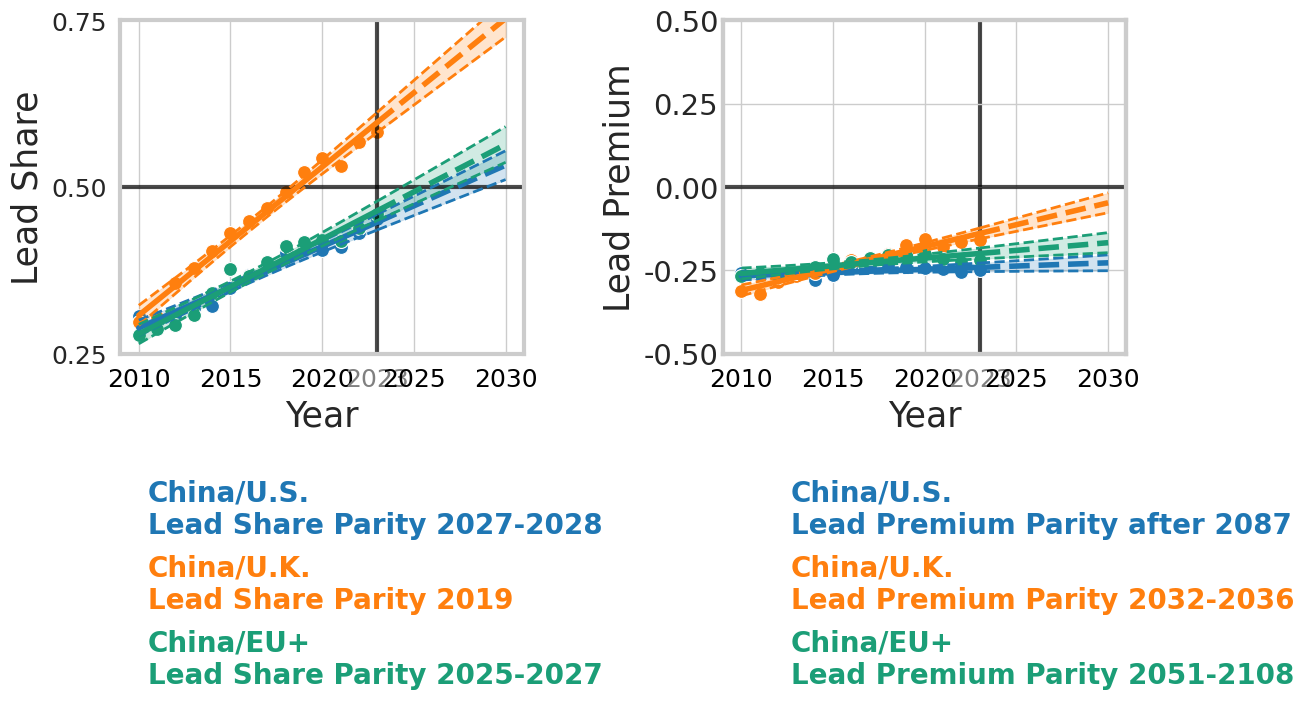

In [11]:
# =========================
# (4) Make the two required figure sets
# =========================
# Set A: China vs US/UK/EU+
pairs_A = [x for x in ["U.S.", "U.K.", "EU+", "China"] if x in c2_draw_list and x!=c1]
partners_str = "_".join(x.replace('.', '').replace('+', 'plus') for x in pairs_A)
plot_two_panels(
    panel_name= f"{c1.replace('.', '')}_vs_{partners_str}",
    pairs_order=pairs_A,
    color_dict=COLOR_GENERAL,
    settings=settings,
    file_suffix=f"two_lead_overtime{file_name_label}",
    x_min=begin_year-1, x_max=2031,
    save_file_name = "fig_1_cd"
)

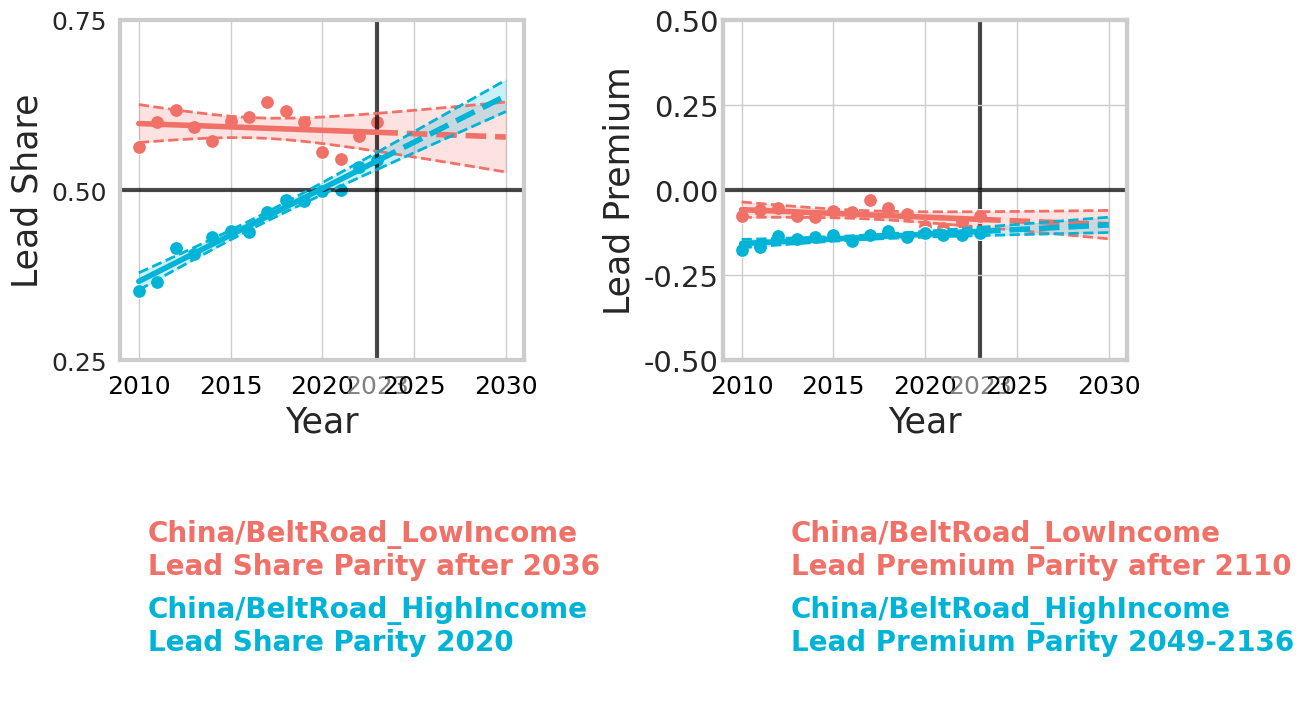

In [12]:
# Set B: China vs BeltRoad groups
pairs_B = [x for x in ["BeltRoad_LowIncome", "BeltRoad_HighIncome"] if x in c2_draw_list]
plot_two_panels(
    panel_name=f"{c1}_BeltRoad",
    pairs_order=pairs_B,
    color_dict=COLOR_BELT,
    settings=settings,
    file_suffix=f"two_lead_overtime_beltroad{file_name_label}",
    x_min=begin_year-1, x_max=2031,
    save_file_name = "fig_4_c"
)